In [1]:
import csv
import pandas as pd
import random
import numpy as np
import math
import time
import os
import matplotlib.pyplot as plt

# Implementation of Our Automatic Labeling Scheme in Paper "A Novel Learning Framework for Sampling-Based Motion Planning in Autonomous Driving"

# Usage 1. Extract lane-changing patterns and car-following patterns (randomly) and driving on-line patterns for training
# (saved as 10 frames per pattern, last frame indicates current frame)
# Output format: 
# 1. BLC-patterns.csv to train stageI model (before-lane-changing model,
# 2. ALC-patterns.csv to train stageII model (After-lane-changing model), not including driving on-line cases
# 3. ALC-OL-patterns.csv to train stageII model, including driving on-line cases
# 4. ALL-patterns.csv to train single model

save_BLC=True # Whether to save each file 
save_ALC=False
save_ALC_OL=True
save_ALL=False

# Usage 2. Find lane-changing start point and end point in 2s before and after cross-over
# (saved as 2 frames per case, start point before cross-over and end point after cross-over)
# Output format: 
# Critical.csv

save_critical_frame=True

# Usage 3. Statistics of lateral distance after cross-over for driving on-line, 1-10s and 11-20s after cross-over
# Output format: 
# .txt

save_statistics=False

# Usage 4. Statistics of lateral distance after cross-over for driving on-line, 1-10s and 11-20s after cross-over
# Output format: 
# .txt

save_critical_theta=False

In [2]:
#Parameters Settings

prev_n=20 # time period to define whether Driving on-line or After-lane-changing, also time period to calculate critical angle
memory_length=10 # length of pattern
num_CF_per_vehicle1=4 # number of car following patterns to save randomly for vehicles without lane-changing throughtout 
num_CF_per_vehicle2=4 # number of car following patterns to save randomly for vehicles with lane-changing 

# Output folder for all time stamps
csv_root="./data/"
if not os.path.exists(csv_root):
    os.mkdir(csv_root)

# Read raw trajectory data from NIGSIM
# time_stamp="/0527pm-0530pm"
# f=pd.read_csv("./I-80-Emeryville-CA/vehicle-trajectory-data"+time_stamp+"/trajectories-"+time_stamp[1:]+".csv")
time_stamp="/0750am-0805am"
f=pd.read_csv("./us101_Dataset/vehicle-trajectory-data"+time_stamp+"/trajectories-"+time_stamp[1:]+".csv")

In [3]:
#Add_new_features, e.g. vx,vy,theta

x=[]
y=[]
x_v=[] #lateral velocity
y_v=[] #longitudinal velocity
theta=[] # velocity angle

local_x=f[["Vehicle_ID","Local_X","Local_Y"]]
Local_X_list=local_x["Local_X"].values
Local_Y_list=local_x["Local_Y"].values
Vehicle_ID_list=local_x["Vehicle_ID"].values
for i in range(len(local_x)):
    if i==0:
        x.append('none')
        x_v.append('none')
        y.append('none')
        y_v.append('none')
        theta.append('none')
    else:
        if Vehicle_ID_list[i]==Vehicle_ID_list[i-1]: 
            dx=Local_X_list[i]-Local_X_list[i-1]
            x.append(dx)
            dy=Local_Y_list[i]-Local_Y_list[i-1]
            y.append(dy)
            vx=dx/0.1
            x_v.append(vx)
            vy=dy/0.1
            y_v.append(vy)
            #with vertical line
            angle=0
            if(vy==0 and vx>0):
                angle=(math.pi/2)
            elif(vy==0 and vx<0):
                angle=(-math.pi/2)
            elif(vy==0 and vx==0):
                angle=0
            else:
                angle=math.atan(vx/vy)
            theta.append(angle)
        else:
            x.append('none')
            x_v.append('none')
            y.append('none')
            y_v.append('none')
            theta.append('none')
    if(i%100000==0):
        print(i)

if not os.path.exists(csv_root+time_stamp):
    os.mkdir(csv_root+time_stamp)
dic={'x_v':x_v,'y_v':y_v,'theta':theta}
df = pd.DataFrame(data=dic)
new_f=pd.concat([f,df],axis=1)
new_f=new_f[new_f["x_v"]!='none']
new_f.to_csv(csv_root+time_stamp+"/add_label.csv",index=False)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [4]:
# def searchCase(data,Vehicle_ID,Frame_ID):
#     for i in range(len(data)):
#         if(data['Vehicle_ID'].values[i]==Vehicle_ID and data['Frame_ID'].values[i]==Frame_ID):
#             f=plt.figure()
#             t_id=i
#             for a in range(40):
#                 print(data['Frame_ID'].values[t_id-prev_n+a+1],data['Lane_ID'].values[t_id-prev_n+a+1])
#                 plt.scatter(data['Local_X'].values[t_id-prev_n+a+1],data['Local_Y'].values[t_id-prev_n+a+1])
#             f.show()
#             break

# searchCase(f,2613,8010)

In [5]:
# Find out all the vehicles that change lane
f=pd.read_csv(csv_root+time_stamp+"/add_label.csv")

# How many vehicles in total
Vehicle_ID=f['Vehicle_ID']
Vehicle_ID_LIST=Vehicle_ID.drop_duplicates().values
print("Number of all vehicles:")
print(len(Vehicle_ID_LIST))


ID=f[['Vehicle_ID','Local_X','Local_Y','Lane_ID','x_v','y_v','theta']]
change_vehicle_id=[]
change_vehicle_row=[]
Vehicle_ID_list=ID['Vehicle_ID'].values
Lane_ID_list=ID['Lane_ID'].values

# Fint out lane-changing vehicles
for i in range(len(f)):
    if i==0:
        continue
    else:
        #including 1-6
        if Vehicle_ID_list[i]==Vehicle_ID_list[i-1] and Lane_ID_list[i]!=Lane_ID_list[i-1]:
            if Vehicle_ID_list[i] not in change_vehicle_id:
                change_vehicle_id.append(Vehicle_ID_list[i])
            change_vehicle_row.append(i-1)
            change_vehicle_row.append(i)        

print("Number of lane-changing vehicles:")
print(len(change_vehicle_id))
print("First 10 IDs: ",change_vehicle_id[:10])

Number of all vehicles:
1993
Number of lane-changing vehicles:
551
First 10 IDs:  [2, 4, 6, 18, 31, 33, 35, 37, 40, 42]


In [6]:
# Get Car Following/Keep Lane Patterns for vehicles without lane-changing throughout
keep_lane_row=[]
kl_num=0
LK_list=[]

for i in Vehicle_ID_LIST:
    if i not in change_vehicle_id:
         LK_list.append(i)            
LK_ID=f[f.Vehicle_ID.isin(LK_list)]
LK_ID=LK_ID[LK_ID.Lane_ID.isin([1,2,3,4,5])]
LK_ID['label_o']=0 #Lateral Movement Orientation, 0 means go straight, 1 means left, 2 means right
LK_ID=LK_ID.reset_index(drop=True)
print("Number of Keep Lane vehicles:",len(LK_list))

#For each vehicle, random select 'memory_length' long interval 
for i in LK_list:
    one_ve_info=LK_ID[LK_ID.Vehicle_ID.isin([i])]
    total_frames=len(one_ve_info)
    if total_frames>=memory_length:
        for i in range(num_CF_per_vehicle1):
            start_frame=random.randint(memory_length,total_frames)-memory_length
            end_frame=start_frame+memory_length
            one_ve_index=one_ve_info.iloc[start_frame:end_frame,:].index
            keep_lane_row.extend(one_ve_index)

print("First Keep Lane pattern:")
print(keep_lane_row[:memory_length+1])

kl_num=len(keep_lane_row)/(memory_length)
print("Number of Keep Lane Patterns: ",kl_num)
KL_train_csv=LK_ID.loc[keep_lane_row]

Number of Keep Lane vehicles: 1442
First Keep Lane pattern:
[323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 355]
Number of Keep Lane Patterns:  5768.0


In [7]:
# # Get Lane-changing vehicle IDs
Change_vehicle=ID[ID.Vehicle_ID.isin(change_vehicle_id)]
change_num=int(len(change_vehicle_row)/2)

Change_local=Change_vehicle.loc[change_vehicle_row]
Change_local=Change_local.reset_index(drop=True)

#Statistics for all possible lane change
lane_local12_row=[]
lane_local21_row=[]
lane_local23_row=[]
lane_local32_row=[]
lane_local34_row=[]
lane_local43_row=[]
lane_local45_row=[]
lane_local54_row=[]
for i in range(len(Change_local)):
    if i ==0:
        continue
    else:
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==2 and Change_local.Lane_ID[i-1]==1:
            lane_local12_row.append(i-1)
            lane_local12_row.append(i)
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==1 and Change_local.Lane_ID[i-1]==2:
            lane_local21_row.append(i-1)
            lane_local21_row.append(i)
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==3 and Change_local.Lane_ID[i-1]==2:
            lane_local23_row.append(i-1)
            lane_local23_row.append(i)
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==2 and Change_local.Lane_ID[i-1]==3:
            lane_local32_row.append(i-1)
            lane_local32_row.append(i)
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==4 and Change_local.Lane_ID[i-1]==3:
            lane_local34_row.append(i-1)
            lane_local34_row.append(i)
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==3 and Change_local.Lane_ID[i-1]==4:
            lane_local43_row.append(i-1)
            lane_local43_row.append(i)
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==5 and Change_local.Lane_ID[i-1]==4:
            lane_local45_row.append(i-1)
            lane_local45_row.append(i)
        if Change_local.Vehicle_ID[i]==Change_local.Vehicle_ID[i-1] and  Change_local.Lane_ID[i]==4 and Change_local.Lane_ID[i-1]==5:
            lane_local54_row.append(i-1)
            lane_local54_row.append(i)

#Fetch data
change_lane12_local=Change_local.loc[lane_local12_row]
change_lane21_local=Change_local.loc[lane_local21_row]
change_lane23_local=Change_local.loc[lane_local23_row]
change_lane32_local=Change_local.loc[lane_local32_row]
change_lane34_local=Change_local.loc[lane_local34_row]
change_lane43_local=Change_local.loc[lane_local43_row]
change_lane45_local=Change_local.loc[lane_local45_row]
change_lane54_local=Change_local.loc[lane_local54_row]
            
Vehicle_ID12=change_lane12_local['Vehicle_ID']
Vehicle_ID12.tolist()
set(Vehicle_ID12)
Vehicle_ID12=set(Vehicle_ID12)

Vehicle_ID21=change_lane21_local['Vehicle_ID']
Vehicle_ID21.tolist()
set(Vehicle_ID21)
Vehicle_ID21=set(Vehicle_ID21)

Vehicle_ID23=change_lane23_local['Vehicle_ID']
Vehicle_ID23.tolist()
set(Vehicle_ID23)
Vehicle_ID23=set(Vehicle_ID23)

Vehicle_ID32=change_lane32_local['Vehicle_ID']
Vehicle_ID32.tolist()
set(Vehicle_ID32)
Vehicle_ID32=set(Vehicle_ID32)

Vehicle_ID34=change_lane34_local['Vehicle_ID']
Vehicle_ID34.tolist()
set(Vehicle_ID34)
Vehicle_ID34=set(Vehicle_ID34)

Vehicle_ID43=change_lane43_local['Vehicle_ID']
Vehicle_ID43.tolist()
set(Vehicle_ID43)
Vehicle_ID43=set(Vehicle_ID43)

Vehicle_ID45=change_lane45_local['Vehicle_ID']
Vehicle_ID45.tolist()
set(Vehicle_ID45)
Vehicle_ID45=set(Vehicle_ID45)

Vehicle_ID54=change_lane54_local['Vehicle_ID']
Vehicle_ID54.tolist()
Vehicle_ID54=set(Vehicle_ID54)

change_lane_ID=Vehicle_ID12|Vehicle_ID21|Vehicle_ID23|Vehicle_ID32|Vehicle_ID34|Vehicle_ID43|Vehicle_ID45|Vehicle_ID54
change_lane_ID=list(change_lane_ID)
print(len(change_lane_ID))

421


In [8]:
# Get lane-changing cases from raw trajectory dataset
CL_train_csv=f[f.Vehicle_ID.isin(change_lane_ID)]
print(len(CL_train_csv))
CL_Vehicle_ID_list=CL_train_csv['Vehicle_ID'].values
CL_Lane_ID_list=CL_train_csv['Lane_ID'].values
CL_ID_list=CL_train_csv.index

# Counters
inspect_1=0
inspect_2=0
inspect_3=0
inspect_4=0
inspect_5=0
inspect_6=0

change_vehicle_row=[]#before cross-over part
change_vehicle_row2=[]#after cross-over part
on_line_row=[]

# Get all 2s before lane-changing
for i in range(len(CL_train_csv)):
    if i<prev_n:
        continue
    else:
        if CL_Vehicle_ID_list[i]==CL_Vehicle_ID_list[i-1]==CL_Vehicle_ID_list[i-prev_n]\
        and CL_Lane_ID_list[i]!=CL_Lane_ID_list[i-1]: # Cross-over points
            if CL_Lane_ID_list[i]<=5 and CL_Lane_ID_list[i-1]<=5: # Lane-changing on lane 1-5
                inspect_1+=1
                
                x=CL_Lane_ID_list[i-prev_n:i]
                lane_num=len(set(x))

                if lane_num==1: # No consecutive 
                    inspect_2+=1
                    change_vehicle_row.extend(CL_ID_list[a] for a in range(i-prev_n,i+1))#save id for marking
                
                if lane_num==2:#get noisy cases/driving on-line cases 
                    inspect_3+=1
                    if(set(x)=={CL_Lane_ID_list[i],CL_Lane_ID_list[i-1]}):
                        inspect_4+=1
                        on_line_row.extend(CL_ID_list[a] for a in range(i-prev_n,i+1))
                    else:
                        print(set(x))
                        
# Get all 2s after lane-changing
for i in range(len(CL_train_csv)):
    if i<prev_n or i-1+prev_n>=len(CL_train_csv):
        continue
    else:
        if CL_Vehicle_ID_list[i]==CL_Vehicle_ID_list[i-1]==CL_Vehicle_ID_list[i-1+prev_n]\
        and CL_Lane_ID_list[i]!=CL_Lane_ID_list[i-1]:  
            if CL_Lane_ID_list[i]<=5 and CL_Lane_ID_list[i-1]<=5:
                inspect_5+=1
                x=CL_Lane_ID_list[i:i+prev_n]
                lane_num=len(set(x))#after
                if lane_num==1:
                    inspect_6+=1
                    change_vehicle_row2.extend(CL_ID_list[a] for a in range(i-1,i+prev_n))#save id for marking        
                    

print(len(change_vehicle_row),len(change_vehicle_row2),len(on_line_row))
print("Total change-lane case case number:")
print(change_num)

CL_train_csv1=CL_train_csv.loc[change_vehicle_row]
CL_train_csv2=CL_train_csv.loc[change_vehicle_row2]

207792
{5, 6}
12495 11382 2583
Total change-lane case case number:
1200


In [9]:
#Processing on line cases
On_Line_Num=len(on_line_row)/(prev_n+1)
print("Number of case: ",On_Line_Num)
obj_list=[(prev_n+1)*i for i in range(int(On_Line_Num))] # Start index of each case in the list
print(obj_list[:10]) #Check first 10 cases

move_distance_noise=[] #statistics purpose
move_vel_noise=[]

OL_case_list=[] # Record start frame, turn point of driving on-line case
On_Line_Right_Frame=[] #lane-changing right frame for driving on-line case 
On_Line_Left_Frame=[] #lane-changing left frame for driving on-line case 

cnt=0
for i in obj_list:
    change_point=on_line_row[i+prev_n]
    new_lane=CL_train_csv.loc[change_point]['Lane_ID']
    old_lane=CL_train_csv.loc[change_point-1]['Lane_ID']
    mark=prev_n
    turn_point=prev_n
    f1=False
    f2=False
    for j in range(1,prev_n):
        if(new_lane>old_lane and CL_train_csv.loc[change_point-j]['Local_X']<\
           CL_train_csv.loc[change_point-j-1]['Local_X'] and f1==False):
            turn_point=j
            f1=True
        if(new_lane<old_lane and CL_train_csv.loc[change_point-j]['Local_X']>\
           CL_train_csv.loc[change_point-j-1]['Local_X'] and f2==False):
            turn_point=j
            f2=True
        if(CL_train_csv.loc[change_point-j]['Lane_ID']==new_lane):
            mark=j
            break
    
    start_point=prev_n-mark+1 #Driving on-line case includes this point 
    turn_point=prev_n-turn_point #First part includes this point
    OL_case_list.append([cnt,start_point,turn_point])
    if(new_lane<old_lane):
        On_Line_Right_Frame.extend(on_line_row[i+j] for j in range(start_point,turn_point+1))
        On_Line_Left_Frame.extend(on_line_row[i+j] for j in range(turn_point+1,prev_n))
    else:
        On_Line_Left_Frame.extend(on_line_row[i+j] for j in range(start_point,turn_point+1))
        On_Line_Right_Frame.extend(on_line_row[i+j] for j in range(turn_point+1,prev_n))
        
    move_distance_noise.extend((CL_train_csv.loc[on_line_row[i+j]]['Local_X']-CL_train_csv.loc[on_line_row[i+start_point-1]]\
                          ['Local_X']) for j in range(start_point,prev_n))
    move_vel_noise.extend((CL_train_csv.loc[on_line_row[i+j]]['x_v']) for j in range(start_point,prev_n))
    cnt+=1


#20-start_point
print(OL_case_list)
print(len(On_Line_Left_Frame),len(On_Line_Right_Frame))
print(On_Line_Left_Frame)

Number of case:  123.0
[0, 21, 42, 63, 84, 105, 126, 147, 168, 189]
[[0, 17, 18], [1, 5, 19], [2, 13, 16], [3, 17, 18], [4, 13, 16], [5, 17, 18], [6, 4, 18], [7, 15, 17], [8, 16, 18], [9, 11, 13], [10, 19, 19], [11, 12, 16], [12, 19, 19], [13, 11, 18], [14, 11, 14], [15, 12, 14], [16, 18, 0], [17, 18, 18], [18, 6, 8], [19, 17, 19], [20, 19, 19], [21, 11, 16], [22, 3, 14], [23, 11, 18], [24, 4, 9], [25, 17, 19], [26, 4, 9], [27, 14, 15], [28, 14, 16], [29, 2, 13], [30, 9, 14], [31, 15, 16], [32, 17, 18], [33, 9, 16], [34, 12, 14], [35, 11, 19], [36, 12, 13], [37, 8, 16], [38, 17, 18], [39, 10, 19], [40, 14, 19], [41, 12, 14], [42, 17, 18], [43, 3, 17], [44, 12, 18], [45, 19, 19], [46, 17, 0], [47, 13, 16], [48, 15, 19], [49, 19, 19], [50, 17, 17], [51, 11, 19], [52, 15, 19], [53, 11, 15], [54, 14, 17], [55, 15, 15], [56, 14, 17], [57, 18, 18], [58, 8, 18], [59, 17, 18], [60, 15, 19], [61, 12, 15], [62, 16, 17], [63, 10, 15], [64, 19, 19], [65, 17, 18], [66, 14, 16], [67, 16, 18], [68, 1

In [10]:
# Save Driving OL Patterns for training
Records_R_OL=[]
for i in range(len(On_Line_Right_Frame)):
    Record_ID=On_Line_Right_Frame[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_R_OL.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_R_OL))

Records_L_OL=[]
for i in range(len(On_Line_Left_Frame)):
    Record_ID=On_Line_Left_Frame[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_L_OL.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_L_OL))
TR_OL=CL_train_csv.loc[Records_R_OL]
TL_OL=CL_train_csv.loc[Records_L_OL]

TR_OL['label_o']=2 #Orientation label for turn right
TL_OL['label_o']=1

4170
4830


Number of After-lane-changing case:  542.0
[192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 7885]


/home/henry/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


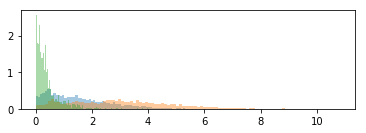

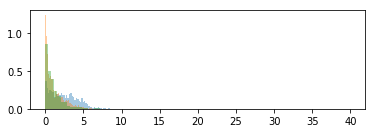

In [11]:
ALC_Num=len(change_vehicle_row2)/(prev_n+1)
ALC_row=change_vehicle_row2
print("Number of After-lane-changing case: ",ALC_Num)
obj_list=[(prev_n+1)*i for i in range(int(ALC_Num))]
print(ALC_row[:22])#Check first case

move_distance_1=[] #statistics purpose
move_distance_2=[]
move_vel_1=[]
move_vel_2=[]

#i+1->i+10 i+11->i+20, i indicates last point before lane-changing
for i in obj_list:
    for j in range(1,11):
        dis=CL_train_csv.loc[ALC_row[i+j]]['Local_X']-CL_train_csv.loc[ALC_row[i]]['Local_X']
        move_distance_1.append(dis)
        move_vel_1.append(CL_train_csv.loc[ALC_row[i+j]]['x_v'])
    for j in range(11,21):
        dis=CL_train_csv.loc[ALC_row[i+j]]['Local_X']-CL_train_csv.loc[ALC_row[i]]['Local_X']
        move_distance_2.append(dis)
        move_vel_2.append(CL_train_csv.loc[ALC_row[i+j]]['x_v'])

                          
abs_move_distance1=abs(np.array(move_distance_1))
abs_move_distance2=abs(np.array(move_distance_2))
abs_move_distance_noise=abs(np.array(move_distance_noise))

abs_move_vel_1=abs(np.array(move_vel_1))
abs_move_vel_2=abs(np.array(move_vel_2))
abs_move_vel_noise=abs(np.array(move_vel_noise))
                                               
plt.subplot(211)                          
kwargs = dict(histtype='stepfilled', alpha=0.4, normed=True, bins=100)
plt.hist(abs_move_distance1, **kwargs)
plt.hist(abs_move_distance2, **kwargs)
plt.hist(abs_move_distance_noise, **kwargs)      
plt.show()
                          
plt.subplot(212)                          
kwargs = dict(histtype='stepfilled', alpha=0.4, normed=True, bins=100)
plt.hist(abs_move_vel_1, **kwargs)
plt.hist(abs_move_vel_2, **kwargs)
plt.hist(abs_move_vel_noise, **kwargs)      
plt.show()

if save_statistics==True:
    np.savetxt(csv_root+time_stamp+"/1s-ALC.txt",abs_move_distance1,delimiter=',')
    np.savetxt(csv_root+time_stamp+"/2s-ALC.txt",abs_move_distance2,delimiter=',')
    np.savetxt(csv_root+time_stamp+"/On-line.txt",abs_move_distance_noise,delimiter=',')

# ar_loadtxt = np.loadtxt('C:/Users/Administrator.USER-20160219OS/Desktop/array.txt',delimiter=',')

In [12]:
# Get critical angle for after-lane-changing case
f2=CL_train_csv2
CL_num=int(len(f2)/(prev_n+1))
print("Number of desired case:",CL_num)

local_x=f2['Local_X'].values
local_y=f2['Local_Y'].values
slope_A=[]
for i in range(CL_num):
    first_frame=i*(prev_n+1)+0
    second_frame=i*(prev_n+1)+1
    last_frame=(i+1)*(prev_n+1)-1
    xs=(local_x[first_frame]+local_x[second_frame])/2
    ys=(local_y[first_frame]+local_y[second_frame])/2
    xl=local_x[last_frame]
    yl=local_y[last_frame]
#     print(xs,ys,xl,yl)
#     break
    if(yl-ys==0):
         print(xs,ys,xl,yl)
#     print((xl-xs)/(yl-ys))
#     break
    theta=math.atan((xl-xs)/(yl-ys))
    slope_A.append(theta)
print(slope_A[0])
print(len(slope_A))

Number of desired case: 542
-0.009159875525744253
542


In [13]:
# Processing After-lane-changing patterns
obj_list=[(prev_n+1)*i for i in range(CL_num)]
print("Number of change lane:",len(obj_list),len(slope_A))
#Derive labels
Theta_list=f2['theta'].values
Vehicle_ID_list=f2['Vehicle_ID'].values
Lane_ID_list=f2['Lane_ID'].values
Local_X_list=f2['Local_X'].values

#_A indicates after-lane-changing case
f2_ID_list=f2.index
TR_row_A=[]
TL_row_A=[]
TR_mark_A=[]
TL_mark_A=[]
TR_mark_list_A=[]
TL_mark_list_A=[]

TR_critical_A=[]
TL_critical_A=[]
cnt1=cnt2=cnt3=cnt4=0

for j in range(len(obj_list)):
    i=obj_list[j]+1
    #slope>0,turn right
    if Lane_ID_list[i]==Lane_ID_list[i-1]+1:
        s=0
        for a in range(prev_n):
            if(Theta_list[i+prev_n-1-a]>=slope_A[j]):
                s=prev_n-1-a#include s
                break
        if(20>s>=10):
            cnt2+=1
        if(0<=s<10):
            cnt1+=1
        TR_mark_A.extend([[j,s]])
        TR_mark_list_A.extend([1]*(s+1)+[0]*(prev_n-s-1))
        TR_row_A.extend(f2_ID_list[i+a] for a in range(prev_n))
        TR_critical_A.append(f2_ID_list[i+s])
    #slope<0,turn left     
    if Lane_ID_list[i]==Lane_ID_list[i-1]-1:
        s=0
        for a in range(prev_n):
            if(Theta_list[i+prev_n-1-a]<=slope_A[j]):
                s=prev_n-1-a#include s
                break
        if(20>s>=10):
            cnt4+=1
        if(0<=s<10):
            cnt3+=1
        TL_mark_A.extend([[j,s]])
        TL_mark_list_A.extend([1]*(s+1)+[0]*(prev_n-s-1))
        TL_row_A.extend(f2_ID_list[i+a] for a in range(prev_n))
        TL_critical_A.append(f2_ID_list[i+s])
# #([s,] include s
print("Turn right<10 and >=10:",cnt1,cnt2,len(TR_mark_A))
print("Turn left<10 and >=10:",cnt3,cnt4,len(TL_mark_A))
print(TR_mark_A)
print(TL_mark_A)
TL20_A=CL_train_csv.loc[TL_row_A]
TR20_A=CL_train_csv.loc[TR_row_A]#for store the index

L_End=CL_train_csv.loc[TL_critical_A]
R_End=CL_train_csv.loc[TR_critical_A]

Number of change lane: 542 542
Turn right<10 and >=10: 50 107 157
Turn left<10 and >=10: 138 247 385
[[5, 19], [6, 12], [8, 18], [20, 15], [21, 11], [23, 19], [27, 17], [29, 7], [30, 11], [31, 12], [36, 8], [37, 19], [39, 5], [40, 12], [42, 13], [46, 17], [47, 6], [50, 19], [61, 11], [63, 19], [67, 15], [68, 12], [69, 10], [75, 15], [76, 19], [78, 19], [84, 8], [86, 15], [88, 12], [93, 12], [96, 12], [97, 17], [100, 9], [103, 18], [105, 19], [109, 7], [110, 13], [111, 4], [118, 6], [119, 12], [125, 4], [134, 14], [136, 7], [153, 19], [154, 17], [168, 11], [170, 14], [173, 16], [174, 19], [176, 7], [177, 19], [180, 19], [182, 10], [184, 1], [185, 10], [186, 6], [188, 19], [190, 8], [196, 16], [198, 19], [200, 7], [202, 13], [203, 6], [205, 6], [218, 14], [226, 18], [229, 14], [231, 14], [232, 15], [233, 4], [239, 17], [240, 11], [243, 12], [244, 13], [245, 3], [248, 6], [251, 19], [252, 17], [254, 8], [255, 6], [261, 5], [265, 19], [266, 17], [281, 11], [283, 6], [286, 14], [288, 15], [

In [14]:
ACL_Frame=[]

TL_ID_list=TL20_A.index.values
Left_Frame_A=[]
for i in range(len(TL_mark_list_A)):
    if(TL_mark_list_A[i]==1):
        Left_Frame_A.append(TL_ID_list[i])
    if(TL_mark_list_A[i]==0):
        ACL_Frame.append(TL_ID_list[i])

TR_ID_list=TR20_A.index.values
Right_Frame_A=[]
for i in range(len(TR_mark_list_A)):
    if(TR_mark_list_A[i]==1):
        Right_Frame_A.append(TR_ID_list[i])
    if(TR_mark_list_A[i]==0):
        ACL_Frame.append(TR_ID_list[i])
        
print("Number of TR,TL cases:",len(Right_Frame_A),len(Left_Frame_A),len(ACL_Frame))
print("Examples:",Left_Frame_A[:13],Left_Frame_A[-13:])

Number of TR,TL cases: 2074 5074 3692
Examples: [193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 7886] [1035189, 1035190, 1035191, 1035192, 1044151, 1044152, 1044153, 1044154, 1044155, 1044156, 1044157, 1044158, 1044159]


In [15]:
Records_L_A=[]
for i in range(len(Left_Frame_A)):
    Record_ID=Left_Frame_A[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_L_A.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_L_A))

Records_R_A=[]
for i in range(len(Right_Frame_A)):
    Record_ID=Right_Frame_A[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_R_A.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_R_A))

Records_ACL=[]
for i in range(len(ACL_Frame)):
    Record_ID=ACL_Frame[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_ACL.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_ACL))

TR_A=CL_train_csv.loc[Records_R_A]
TL_A=CL_train_csv.loc[Records_L_A]
K_ACL=CL_train_csv.loc[Records_ACL]
TR_A['label_o']=2
TL_A['label_o']=1
K_ACL['label_o']=0
print("Length of TR,TL: ",len(TR_A),len(TL_A),len(K_ACL))

50630
20740
36920
Length of TR,TL:  20740 50630 36920


In [16]:
# Get critical angle for before-lane-changing case
f2=CL_train_csv1
CL_num=int(len(f2)/(prev_n+1))
print("Number of desired case:",CL_num)

local_x=f2['Local_X'].values
local_y=f2['Local_Y'].values
slope=[]
for i in range(CL_num):
    first_frame=i*(prev_n+1)
    mid_frame=(i+1)*(prev_n+1)-2
    last_frame=(i+1)*(prev_n+1)-1
    xs=local_x[first_frame]
    ys=local_y[first_frame]
    xl=(local_x[last_frame]+local_x[mid_frame])/2
    yl=(local_y[last_frame]+local_y[mid_frame])/2
    #print(xs,ys,xl,yl)
    #break
    if(yl-ys==0):
        print(yl,ys,first_frame,last_frame)
    theta=math.atan((xl-xs)/(yl-ys))
    if(abs(theta)<0.0002):
        print("Case",i,theta)
    slope.append(theta)
print(slope[0])
print(len(slope))

Number of desired case: 595
Case 22 -0.00010598589887046663
Case 121 -0.000141837503924537
Case 567 0.00013803257481122353
994.689 994.689 12348 12368
-0.04761637534060354
595


/home/henry/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


2
0 187 17.014 739.0 2
1 188 16.986 743.5 2
2 189 16.957 747.9989999999998 2
3 190 16.929000000000002 752.4989999999998 2
4 191 16.901 756.9989999999998 2
5 192 16.872 761.5 2
6 193 16.844 765.9939999999998 2
7 194 16.816 770.482 2
8 195 16.8 774.9960000000002 2
9 196 16.671 779.6010000000001 2
10 197 16.432000000000002 784.3589999999998 2
11 198 16.127 789.253 2
12 199 15.768 794.275 2
13 200 15.338 799.46 2
14 201 14.899 804.711 2
15 202 14.472 809.9689999999998 2
16 203 14.059 815.177 2
17 204 13.67 820.285 2
18 205 13.231 825.257 2
19 206 12.774 830.123 2
20 207 12.34 834.94 1
0 -0.006222141924133733
1 -0.006222141924132943
2 -0.006445787589798632
3 -0.006222141924132943
4 -0.006222141924133733
5 -0.006442923511073746
6 -0.006230448974880643
7 -0.0062387782361311
8 -0.0035445132906980906
9 -0.02800570521104688
10 -0.050189006101612775
11 -0.06224071334224025
12 -0.07136406829181803
13 -0.08274218961113705
14 -0.08340915516141145
15 -0.08103176285770469
16 -0.07913546717875011
17 -0

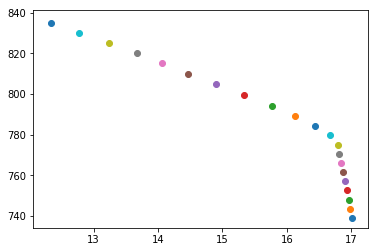

In [17]:
# show one case 20s 
def showcase(q_id,offset,vid,x,y,f,lane,theta):
    print(vid[offset])
    for j in range(prev_n+1):
        plt.scatter(x[offset+j],y[offset+j])
        print(offset+j,f[offset+j],x[offset+j],y[offset+j],lane[offset+j])
    for j in range(prev_n+1):
        print(offset+j,theta[offset+j])
    print("Slope:")
    print(slope[q_id])

q_id=0
showcase(q_id,0+q_id*(prev_n+1),f2['Vehicle_ID'].values,f2['Local_X'].values,f2['Local_Y'].values,f2['Frame_ID'].values,f2['Lane_ID'].values,f2['theta'].values)

In [18]:
#save slope for statistics
print(len(slope),len(slope_A))
change_lane_theta=slope+slope_A
print(len(change_lane_theta))
change_lane_theta=np.array(change_lane_theta)
if save_critical_theta==True:
    np.savetxt(csv_root+time_stamp+"/critical-angle.txt",change_lane_theta,delimiter=',')

print("minimal theta: ",np.min(np.abs(change_lane_theta)))
change_lane_theta

595 542
1137
minimal theta:  0.00010598589887046663


array([-0.04761638, -0.06927664, -0.04860374, ...,  0.07088668,
       -0.0384831 ,  0.04820137])

In [19]:
# Processing Before-lane-changing patterns
# also find interval [s,] for each lane-changing frame
obj_list=[(prev_n+1)*i-1 for i in range(CL_num+1)]
obj_list=obj_list[1:]
print("Number of change lane:",len(obj_list),len(slope))

#Calculate labels
f2_ID_list=f2.index
Theta_list=f2['theta'].values
Vehicle_ID_list=f2['Vehicle_ID'].values
Lane_ID_list=f2['Lane_ID'].values
Local_X_list=f2['Local_X'].values

# No _A indicates before-lane-changing case
TR_row=[]
TL_row=[]
TR_mark=[]
TL_mark=[]
TR_mark_list=[]
TL_mark_list=[]

TR_critical=[]
TL_critical=[]
cnt1=cnt2=cnt3=cnt4=0
for j in range(len(obj_list)):
    i=obj_list[j]
    #slope>0,turn right
    if Lane_ID_list[i]==Lane_ID_list[i-1]+1:
        s=20
        for a in range(prev_n):
            if(Theta_list[i-prev_n+a]>=slope[j]):
                s=a
                break
        if(20>s>=10):
            cnt2+=1
        if(0<=s<10):
            cnt1+=1
        TR_mark.extend([[j,s]])
        TR_mark_list.extend([0]*s+[1]*(prev_n-s))
        TR_row.extend(f2_ID_list[i-prev_n+a] for a in range(prev_n))
        TR_critical.append(f2_ID_list[i-prev_n+s])
    #slope<0,turn left     
    if Lane_ID_list[i]==Lane_ID_list[i-1]-1:
        s=20
        for a in range(prev_n):
            if(Theta_list[i-prev_n+a]<=slope[j]):
                s=a
                break
        if(20>s>=10):
            cnt4+=1
        if(0<=s<10):
            cnt3+=1
        TL_mark.extend([[j,s]])
        TL_mark_list.extend([0]*s+[1]*(prev_n-s))
        TL_row.extend(f2_ID_list[i-prev_n+a] for a in range(prev_n))
        TL_critical.append(f2_ID_list[i-prev_n+s])

# #([s,] include s
print("Turn right<10 and >=10:",cnt1,cnt2,len(TR_mark))
print("Turn left<10 and >=10:",cnt3,cnt4,len(TL_mark))
print(TR_mark)
print(TL_mark)
TL20=CL_train_csv.loc[TL_row]
TR20=CL_train_csv.loc[TR_row]#for store the index

L_Start=CL_train_csv.loc[TL_critical]
R_Start=CL_train_csv.loc[TR_critical]

Number of change lane: 595 595
Turn right<10 and >=10: 135 84 219
Turn left<10 and >=10: 297 79 376
[[3, 8], [6, 12], [7, 8], [9, 4], [22, 0], [23, 5], [25, 12], [27, 16], [32, 11], [34, 14], [35, 12], [36, 0], [41, 7], [42, 0], [43, 0], [44, 15], [46, 14], [48, 14], [49, 10], [51, 2], [55, 0], [56, 10], [57, 7], [58, 1], [60, 2], [61, 17], [63, 0], [68, 1], [73, 9], [74, 1], [75, 16], [76, 13], [80, 7], [81, 5], [82, 1], [88, 9], [91, 7], [95, 1], [97, 14], [98, 1], [100, 10], [102, 12], [103, 12], [104, 0], [107, 4], [108, 13], [111, 10], [112, 13], [113, 13], [116, 0], [118, 11], [119, 12], [121, 10], [123, 7], [125, 6], [126, 14], [129, 5], [133, 7], [134, 1], [140, 7], [150, 12], [151, 3], [153, 11], [155, 9], [162, 0], [169, 2], [173, 16], [174, 0], [175, 11], [176, 14], [178, 1], [180, 2], [186, 4], [193, 8], [196, 0], [197, 0], [200, 12], [201, 13], [203, 7], [204, 0], [206, 18], [207, 19], [209, 0], [211, 2], [212, 10], [213, 7], [214, 5], [216, 10], [223, 0], [224, 3], [226, 

In [20]:
BCL_Frame=[]
TL_ID_list=TL20.index.values
Left_Frame=[]
for i in range(len(TL_mark_list)):
    if(TL_mark_list[i]==1):
        Left_Frame.append(TL_ID_list[i])
    if(TL_mark_list[i]==0):
        BCL_Frame.append(TL_ID_list[i])

TR_ID_list=TR20.index.values
Right_Frame=[]
for i in range(len(TR_mark_list)):
    if(TR_mark_list[i]==1):
        Right_Frame.append(TR_ID_list[i])
    if(TR_mark_list[i]==0):
        BCL_Frame.append(TR_ID_list[i])

print("Number of TR,TL cases:",len(Right_Frame),len(Left_Frame),len(BCL_Frame))

Number of TR,TL cases: 2884 5633 3383


In [21]:
Records_L=[]
for i in range(len(Left_Frame)):
    Record_ID=Left_Frame[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_L.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_L))

Records_R=[]
for i in range(len(Right_Frame)):
    Record_ID=Right_Frame[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_R.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_R))

Records_BCL=[]
for i in range(len(BCL_Frame)):
    Record_ID=BCL_Frame[i]
    if (Record_ID-memory_length+1) not in CL_ID_list:
        continue
    if(CL_train_csv.loc[Record_ID-memory_length+1].Vehicle_ID==CL_train_csv.loc[Record_ID].Vehicle_ID):
        Records_BCL.extend(Record_ID-memory_length+1+a for a in range(memory_length))
print(len(Records_BCL))

TR=CL_train_csv.loc[Records_R]
TL=CL_train_csv.loc[Records_L]
K_BCL=CL_train_csv.loc[Records_BCL]

TR['label_o']=2
TL['label_o']=1
K_BCL['label_o']=0
print("Length of TR,TL: ",len(TR),len(TL),len(K_BCL))

56330
28790
33520
Length of TR,TL:  28790 56330 33520


In [22]:
# Combine different patterns
print(len(Right_Frame),len(Left_Frame),len(On_Line_Left_Frame),len(On_Line_Right_Frame),len(Right_Frame_A),len(Left_Frame_A))
Exc=Right_Frame+Left_Frame+On_Line_Right_Frame+On_Line_Left_Frame+Right_Frame_A+Left_Frame_A

print(len(Exc))

2884 5633 483 417 2074 5074
16565


In [23]:
# Get Car Following cases from vehicles with lane-changing behaviors
Records_K=[]
good_car=0
print("Num of change_lane_vehicle:",len(change_vehicle_id))

for v in change_lane_ID:
    one_ve_info=CL_train_csv[CL_train_csv.Vehicle_ID.isin([v])]# index exist
    one_ve_index=one_ve_info.index
    one_ve_lane=one_ve_info['Lane_ID'].values
    one_ve_frames=one_ve_info['Frame_ID'].values
    total_frames=len(one_ve_info)
    if(total_frames>=prev_n):
        good_car+=1
        for i in range(num_CF_per_vehicle2):#num_per_vehicle
            stop=0
            while True:
                stop+=1
                if(stop==50):
                    break
                k=random.randint(prev_n,total_frames)#>prev_n in order to increase accuracy
                
                x=one_ve_lane[k-prev_n:k]
                remain=min(prev_n,total_frames-k)
                x_remain=one_ve_lane[k-1:k-1+remain]
                
                if(6 not in set(x) and 7 not in set(x) and 8 not in set(x) and \
                  6 not in set(x_remain) and 7 not in set(x_remain) and 8 not in set(x_remain)):
                    k_id=one_ve_index[k-1]#kth frame's index
                    if k_id in Exc:
                        continue
                    Records_K.extend(k_id-memory_length+a+1 for a in range(memory_length))
                    break

                    print("Good car",good_car)

print(len(Records_K))
KL1=CL_train_csv.loc[Records_K]
KL1['label_o']=0

Num of change_lane_vehicle: 551
16840


In [24]:
# Get different datasets
df_combine_B= pd.concat([TR,TL, KL1, K_BCL], ignore_index=True)#Before 
df_combine_A= pd.concat([TR_A,TL_A, KL1, K_ACL], ignore_index=True)#After
df_combine_An= pd.concat([TR_A,TL_A,KL1,K_ACL,TL_OL,TR_OL], ignore_index=True)#After
df_combine= pd.concat([TR,TL, TR_A,TL_A, K_BCL,K_ACL,KL1,TL_OL,TR_OL], ignore_index=True)#all

L_Start['note']='LS'
L_End['note']='LE'
R_Start['note']='RS'
R_End['note']='RE'
df_critical=pd.concat([L_Start,R_Start,L_End,R_End], ignore_index=True)
df_critical=df_critical[['Vehicle_ID','Frame_ID','note']]
df_critical['time']=time_stamp[1:]

In [25]:
F1=KL_train_csv[['Vehicle_ID','Frame_ID','Local_X','Local_Y','v_Vel','v_Acc','Lane_ID','x_v','theta','label_o']]
F2=df_combine_B[['Vehicle_ID','Frame_ID','Local_X','Local_Y','v_Vel','v_Acc','Lane_ID','x_v','theta','label_o']]
F3=df_combine_A[['Vehicle_ID','Frame_ID','Local_X','Local_Y','v_Vel','v_Acc','Lane_ID','x_v','theta','label_o']]
F4=df_combine[['Vehicle_ID','Frame_ID','Local_X','Local_Y','v_Vel','v_Acc','Lane_ID','x_v','theta','label_o']]

F5=df_combine_An[['Vehicle_ID','Frame_ID','Local_X','Local_Y','v_Vel','v_Acc','Lane_ID','x_v','theta','label_o']]

F_Model1=pd.concat([F1,F2], ignore_index=True)
F_Model2=pd.concat([F1,F3], ignore_index=True)
F_Model2n=pd.concat([F1,F4], ignore_index=True)
F_Model=pd.concat([F1,F5], ignore_index=True)

if(save_BLC==True):
    F_Model1.to_csv(csv_root+time_stamp+"/BLC-patterns.csv",index=False)
if(save_ALC==True):
    F_Model2.to_csv(csv_root+time_stamp+"/ALC-patterns.csv",index=False)
if(save_ALC_OL==True):
    F_Model2n.to_csv(csv_root+time_stamp+"/ALC-OL-patterns.csv",index=False)
if(save_ALL==True):
    F_Model.to_csv(csv_root+time_stamp+"/ALL-patterns.csv",index=False)

if(save_critical_frame==True):
    df_critical.to_csv(csv_root+time_stamp+"/Critical.csv",index=False)

In [26]:
df_critical

,Vehicle_ID,Frame_ID,note,time
0,2,197,LS,0750am-0805am
1,31,339,LS,0750am-0805am
2,37,145,LS,0750am-0805am
3,40,267,LS,0750am-0805am
4,42,545,LS,0750am-0805am
5,49,289,LS,0750am-0805am
6,51,364,LS,0750am-0805am
7,56,315,LS,0750am-0805am
8,63,397,LS,0750am-0805am
9,64,365,LS,0750am-0805am


In [27]:
R_Start

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,...,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,theta,x_v,y_v,note
9987,37,505,408,1118847029400,22.286,1983.959,6452581.985,1872034.311,17.5,7.4,...,8.45,2,0,49,0.00,0.00,0.028554,1.76,61.62,RS
11776,44,211,379,1118847000000,9.481,361.736,6451370.707,1873114.993,16.0,6.9,...,11.20,1,43,54,60.60,1.28,0.059538,2.77,46.47,RS
11880,44,315,379,1118847010400,18.593,912.681,6451775.914,1872741.052,16.0,6.9,...,3.69,2,37,49,58.42,1.08,0.070249,3.78,53.72,RS
13375,49,510,411,1118847029900,20.013,1876.662,6452501.058,1872106.010,16.5,5.4,...,11.20,2,37,64,139.47,2.11,0.042859,2.80,65.29,RS
28076,104,701,500,1118847049000,12.530,1908.535,6452530.382,1872090.695,17.5,7.4,...,-11.20,1,115,121,123.12,2.22,0.021008,1.18,56.16,RS
29401,114,629,421,1118847041800,32.669,1842.147,6452466.790,1872119.083,18.5,5.9,...,-3.98,3,96,118,259.93,4.36,0.036804,2.21,60.02,RS
29713,115,515,469,1118847030400,10.024,1122.538,6451939.861,1872609.715,16.0,6.9,...,-7.52,1,104,121,37.67,1.13,0.047654,1.60,33.55,RS
30321,116,666,455,1118847045500,23.172,1871.368,6452495.053,1872107.053,21.5,5.4,...,6.11,2,105,120,74.39,1.31,0.018689,1.06,56.71,RS
33828,125,685,443,1118847047400,31.626,1871.252,6452489.396,1872100.769,16.0,5.9,...,11.20,3,124,142,93.24,1.58,0.036761,2.15,58.46,RS
35196,132,390,466,1118847017900,9.574,379.022,6451383.372,1873103.194,15.5,7.4,...,1.27,1,121,134,124.00,3.10,0.065918,2.63,39.84,RS
